In [1]:
import pandas as pd

In [2]:
titanic_df = pd.read_csv("small.csv")
len(titanic_df.columns)

8

In [3]:
for column in titanic_df.columns:
    print(f"{column}: {titanic_df[column].unique()}")

age: [1 2 3]
portembarked: [1 2 3]
fare: [1 2 3]
numparentschildren: [1 2 3]
passengerclass: [1 2 3]
sex: [1 2]
numsiblings: [1 2 3]
survived: [1 2]


In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from utils.graph import Node, DAG

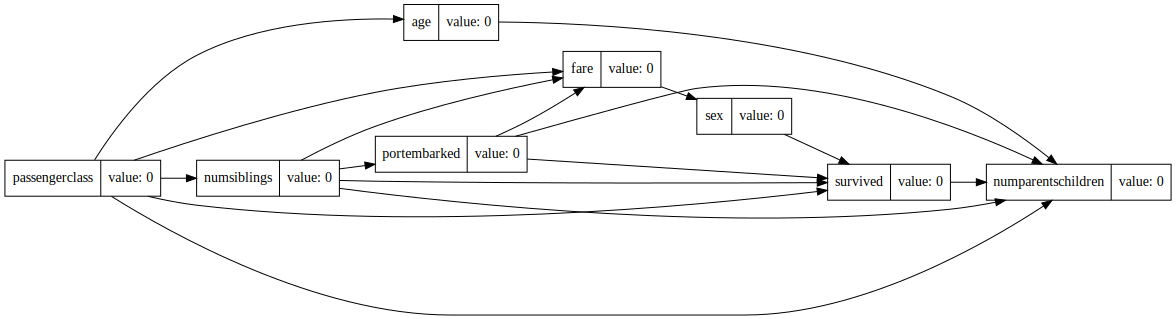

In [6]:
dag = DAG(set([Node(variable=col) for col in titanic_df.columns]), randomize=True)
dag.draw_dot_from_digraph()

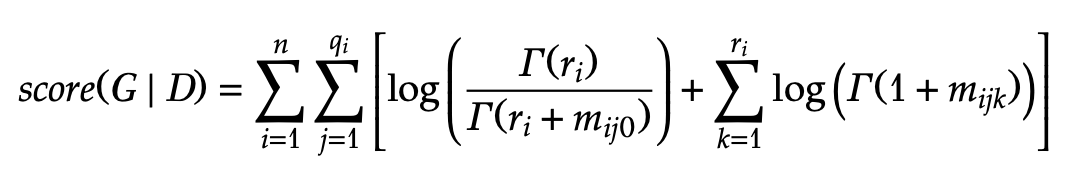
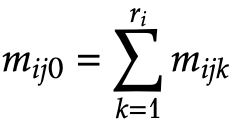

Our goal is to implement this function. Lets make sure we have everything defined:
- G = the graph
- D = the data
- n = the number of variables
- q_i = the number of possible values of the parents of Xi, which is 2^k if there are k parents and all our variables are binary
- r_i = the number of possible values our Xi variable can take
- m_ijk = the number of times in our data that the variable Xi takes the value k, and the parents of Xi take the jth configuration instantation 

In [7]:
from itertools import product
from math import log
from scipy.special import loggamma

def bayesian_dirichilet_score(graph: DAG, data: pd.DataFrame):
    total_sum = 0
    variable_unique_counts = {variable: data[variable].unique() for variable in data.columns}

    # For each node we need to iterate over all the possible configurations of the parents
    for node in graph.nodes:
        possible_values = variable_unique_counts[node.variable]
        
        parents = node.prev
        parent_variables = [parent.variable for parent in parents]
        parent_configurations = generate_parent_configurations(node, variable_unique_counts, data)
        
        r_i = len(possible_values)
        
        left_sum = 0
        # The possible configurations are generated via the cartesian product
        for config in parent_configurations:
            m_ij0 = 0

            # Build the DataFrame query that matches our parent configuration
            base_string = ""
            for (key,value) in zip(parent_variables, config):
                base_string += f"{key} == {value} & "

            right_sum = 0
            for k in possible_values:
                query_string = base_string + f"{node.variable} == {k}"
                # Find all observations that have our parent configuration and a value of k for this node
                m_ijk = len(data.query(query_string))
                # We keep track of m_ij0 here to reduce the DataFrame queries
                # Count all instances of this parent configuration across all values of Xi
                m_ij0 += m_ijk
                right_sum += loggamma(1 + m_ijk)

            left_sum += (loggamma(r_i) - loggamma(r_i + m_ij0)) + right_sum

        total_sum += left_sum
    return total_sum

def generate_parent_configurations(node: Node, unique_counts: dict, data: pd.DataFrame):
    parents = node.prev
    possible_values = [unique_counts[parent.variable] for parent in parents]
    return list(product(*possible_values))


In [8]:
bayesian_dirichilet_score(dag, titanic_df)

-4039.127172792286

In [9]:
dag.bayesian_dirichilet_score(titanic_df)

-4039.127172792286

In [10]:
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

edges = [(parent.variable, child.variable) for child in dag.nodes for parent in child.prev]
model = BayesianModel(edges)

bdeu = BDeuScore(titanic_df)

print(bdeu.score(model))
print(dag.bayesian_dirichilet_score(titanic_df))

/Users/ellington/opt/anaconda3/envs/bn-learner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ellington/opt/anaconda3/envs/bn-learner/lib/python3.10/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


-3982.956612042942
-4039.127172792286
